In [2]:
import numpy as np
import scipy as spy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import warnings
warnings.filterwarnings('ignore')

In [5]:
returns = pd.read_csv('/Users/nanyueming/Documents/学习/量化策略/弗居投资面试题/Data/returns_20181228.csv',
                      index_col = 0,
                      parse_dates = True)

In [6]:
returns.head()

,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,stock_9,...,stock_1131,stock_1132,stock_1133,stock_1134,stock_1135,stock_1136,stock_1137,stock_1138,stock_1139,stock_1140
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,-0.561639,0.113423,-1.580584,-0.017527,1.055723,1.306785,-0.692687,1.303057,-0.243042,0.081520,...,1.410213,-0.307705,0.829215,-0.505364,0.232976,-0.393465,-0.471561,-0.308961,-0.202832,-0.205398
1990-01-04,-1.841947,0.463435,-1.172764,0.513875,2.470817,0.463057,0.427191,-0.737959,1.455408,0.971196,...,-0.656517,-1.327001,0.770307,0.485192,-0.199085,-0.590958,-0.513262,0.369685,-0.549467,0.279644
1990-01-05,-0.277859,0.216396,-0.429848,0.802112,2.686740,0.059472,-0.895917,-0.785620,0.022776,-1.336882,...,0.098997,0.197211,-2.003799,2.101860,0.442342,-0.677487,-0.955708,0.926602,-0.762952,2.046626
1990-01-08,-0.881483,1.867996,-1.659936,0.313561,0.868181,-1.923021,-1.788387,2.902709,0.600026,-0.943956,...,-0.366244,0.480905,-0.780784,-0.131875,-0.657870,-1.526045,-0.140225,1.410707,0.168989,0.787590
1990-01-09,-0.534578,0.413210,0.004407,1.223128,0.972728,1.420754,1.864039,1.564482,0.243046,1.345295,...,1.469816,0.017081,-1.603788,-2.895389,0.540079,-1.126372,-1.737689,1.036790,1.243899,0.069950


首先处理数据，将含有0值的股票删掉

In [37]:
for stock in returns.columns:
    if sum( returns[stock] == 0 ) > 0:
        returns.drop(stock , axis = 1 , inplace = True)

In [38]:
len(returns.columns)

1030

观察一下单个股票价格走势

In [83]:
returns['p0'] = 1.0
for i in range(len(returns.index)-1):
    returns['p0'][i+1] = returns['p0'][i] + returns['stock_0'][i]

<AxesSubplot:xlabel='Date'>

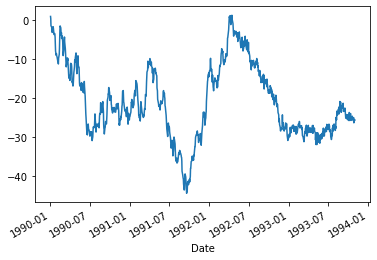

In [84]:
returns['p0'].plot()

    根据题目叙述，股票收益率是由动量因子和均值回复因子生成，在一些时段，呈现动量效应，一些时段呈现均值回复效应。

    1、首先，需要找到效应转变的时间节点

动量效应体现为 正收益大概率跟随正收益

按定义来说，首先尝试计算相邻两期的相关系数，为正则为动量效应，为负则为均值回复效应

In [45]:
returns['serial_correlation'] = 0.0

In [46]:
for i in range(len(returns.index)-1):
    ts1 = pd.Series(returns.T[returns.index[i]].values)
    ts2 = pd.Series(returns.T[returns.index[i+1]].values)
    
    corr = ts1.corr(ts2 , method = 'spearman')
    returns['serial_correlation'][i+1] = corr

<AxesSubplot:xlabel='Date'>

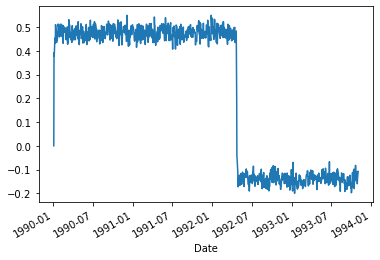

In [47]:
returns['serial_correlation'].plot()

已经可以明显观察到效应转换的时间节点

In [49]:
for i in range(len(returns.index)-1):
    if returns.serial_correlation[i]>0 and returns.serial_correlation[i+1]<0 :
        print(returns.index[i+1])

1992-04-23 00:00:00


效应转换的时间为1992-4-23

    2、接下来计算平均动量。平均动量定义为时段内所有股票的平均回报

In [64]:
#这个算法太暴力了

#row , col = np.shape(returns[returns.index<'1992-04-23'].values)
#stocks_r = []
#for i in range(row):
#    for j in range(col):
#        return_array = returns[returns.index<'1992-04-23'].values
#        stocks_r.append(return_array[i][j])

In [74]:
returns[returns.index < '1992-04-23'].mean().mean()

0.6834443860297916

动量效应均值：0.68

In [76]:
returns[returns.index >= '1992-04-23'].mean().mean()

0.6812639621620221

均值回复效应均值：0.68

    3、为什么会出现效应的转换

从行为金融学角度来分析，股票价格存在一定规律性。

当股票价格因内部原因或市场原因需要进行估值调整时，会进入单边上涨或下跌行情，此时表现为动量效应。

在价格调整到位之前，该单边行情不会停止，顺势交易将能获得收益。

而价格并不会一次性调整到位，当出现价格超调时，趋势将发生反转。

此时单边行情结束，市场进入震荡行情以寻找公允价格，即均值回复效应。